In [1]:
%load_ext autoreload
%autoreload 2

from typing import Optional, Tuple
from pathlib import Path
import collections
import functools
from functools import partial
import itertools
import math
import os

# Change default behavior of jax GPU memory allocation.
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".20"

# visualization libraries
%matplotlib inline
from pprint import pprint
from icecream import ic
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import scipy
import skimage
import torch
import torch.nn.functional as F
import functorch
import einops
import monai
import dipy
import dipy.reconst
import dipy.reconst.csdeconv, dipy.reconst.shm, dipy.viz
import dipy.denoise
import dipy.io
import dipy.io.streamline
import nibabel as nib

import jax
import jax.config

# Disable jit for debugging.
# jax.config.update("jax_disable_jit", True)
# Enable 64-bit precision.
# jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_default_matmul_precision", 32)
import jax.numpy as jnp
from jax import lax
import jax.dlpack

import pitn


plt.rcParams.update({"figure.autolayout": True})
plt.rcParams.update({"figure.facecolor": [1.0, 1.0, 1.0, 1.0]})
plt.rcParams.update({"image.cmap": "gray"})
plt.rcParams.update({"image.interpolation": "antialiased"})

# Set print options for ndarrays/tensors.
np.set_printoptions(suppress=True, threshold=100, linewidth=88)
torch.set_printoptions(sci_mode=False, threshold=100, linewidth=88)

In [2]:
# torch setup
# allow for CUDA usage, if available
if torch.cuda.is_available():
    # Pick only one device for the default, may use multiple GPUs for training later.
    dev_idx = 0
    device = torch.device(f"cuda:{dev_idx}")
    print("CUDA Device IDX ", dev_idx)
    torch.cuda.set_device(device)
    print("CUDA Current Device ", torch.cuda.current_device())
    print("CUDA Device properties: ", torch.cuda.get_device_properties(device))
    # The flag below controls whether to allow TF32 on matmul. This flag defaults to False
    # in PyTorch 1.12 and later.
    torch.backends.cuda.matmul.allow_tf32 = True
    # See
    # <https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices>
    # for details.
    torch.set_float32_matmul_precision("medium")

    # Activate cudnn benchmarking to optimize convolution algorithm speed.
    if torch.backends.cudnn.enabled:
        torch.backends.cudnn.benchmark = True
        print("CuDNN convolution optimization enabled.")
        # The flag below controls whether to allow TF32 on cuDNN. This flag defaults to True.
        torch.backends.cudnn.allow_tf32 = True

else:
    device = torch.device("cpu")
# keep device as the cpu
# device = torch.device('cpu')
print(device)

CUDA Device IDX  0
CUDA Current Device  0
CUDA Device properties:  _CudaDeviceProperties(name='NVIDIA RTX A5000', major=8, minor=6, total_memory=24247MB, multi_processor_count=64)
CuDNN convolution optimization enabled.
cuda:0


In [3]:
hcp_full_res_data_dir = Path("/data/srv/data/pitn/hcp")
hcp_full_res_fodf_dir = Path("/data/srv/outputs/pitn/hcp/full-res/fodf")
hcp_low_res_data_dir = Path("/data/srv/outputs/pitn/hcp/downsample/scale-2.00mm/vol")
hcp_low_res_fodf_dir = Path("/data/srv/outputs/pitn/hcp/downsample/scale-2.00mm/fodf")
fibercup_fodf_dir = Path("/data/srv/outputs/fibercup/fiberfox_replication/B1-3/fodf")

assert hcp_full_res_data_dir.exists()
assert hcp_full_res_fodf_dir.exists()
assert hcp_low_res_data_dir.exists()
assert hcp_low_res_fodf_dir.exists()
assert fibercup_fodf_dir.exists()

## Seed-Based Tractography Test

### Data & Parameter Selection

In [4]:
# HCP Subject scan.
# sample_fod_f = (
#     hcp_full_res_fodf_dir / "162329" / "T1w" / "postproc_wm_msmt_csd_fod.nii.gz"
# )
# fod_coeff_im = nib.load(sample_fod_f)
# fod_coeff_im = nib.as_closest_canonical(fod_coeff_im)
# print("Original shape", fod_coeff_im.shape)
# print("Original affine", fod_coeff_im.affine)
# mask_f = sample_fod_f.parent / "postproc_nodif_brain_mask.nii.gz"
# mask_im = nib.load(mask_f)
# mask_im = nib.as_closest_canonical(mask_im)
# white_matter_mask_f = sample_fod_f.parent / "postproc_5tt_parcellation.nii.gz"
# wm_mask_im = nib.load(white_matter_mask_f)
# wm_mask_im = nib.as_closest_canonical(wm_mask_im)
# wm_mask_im = wm_mask_im.slicer[..., 2]

# # Pre-select voxels of interest in RAS+ space for this specific subject.
# lobe_vox_idx = dict(
# # CC forceps minor, strong L-R uni-modal lobe
# cc_lr_lobe_idx = (55, 98, 53),
# # Dual-polar approx. equal volume fiber crossing
# lr_and_ap_bipolar_lobe_idx = (70, 106, 54),
# # Vox. adjacent to CST, tri-polar
# tri_polar_lobe_idx = (60, 68, 43),
# )

In [5]:
# Fibercup phantom data.
sample_fod_f = fibercup_fodf_dir / "B1-3_bval-1500_wm_fod_coeffs.nii.gz"
fod_coeff_im = nib.load(sample_fod_f)
fod_coeff_im = nib.as_closest_canonical(fod_coeff_im)
print("Original shape", fod_coeff_im.shape)
print("Original affine", fod_coeff_im.affine)
mask_f = fibercup_fodf_dir.parent / "dwi" / "B1-3_mask.nii.gz"
mask_im = nib.load(mask_f)
mask_im = nib.as_closest_canonical(mask_im)
white_matter_mask_f = mask_f
wm_mask_im = nib.load(white_matter_mask_f)
wm_mask_im = nib.as_closest_canonical(wm_mask_im)

# Pre-select voxels of interest in RAS+ space.
lobe_vox_idx = dict(
    unipole_lr_c_lobe_idx=(51, 40, 1),
    unipole_left_A_lobe_idx=(41, 34, 1),
    bipole_lr_left_A_lobe_idx=(45, 24, 1),
    two_crossing_center_A_lobe_idx=(32, 47, 1),
    three_crossing_right_A_lobe_idx=(24, 39, 1),
)

Original shape (64, 64, 3, 45)
Original affine [[   3.    0.    0. -189.]
 [   0.    3.    0. -189.]
 [   0.    0.    3.    0.]
 [   0.    0.    0.    1.]]


In [6]:
# Re-orient volumes from RAS to SAR (xyz -> zyx)
nib_affine_vox2ras_mm = fod_coeff_im.affine
affine_ras_vox2ras_mm = torch.from_numpy(nib_affine_vox2ras_mm).to(device)
ornt_ras = nib.orientations.io_orientation(nib_affine_vox2ras_mm)
ornt_sar = nib.orientations.axcodes2ornt(("S", "A", "R"))
ornt_ras2sar = nib.orientations.ornt_transform(ornt_ras, ornt_sar)
# We also need an affine that maps from SAR -> RAS
affine_sar2ras = nib.orientations.inv_ornt_aff(
    ornt_ras2sar, tuple(fod_coeff_im.shape[:-1])
)
affine_sar2ras = torch.from_numpy(affine_sar2ras).to(affine_ras_vox2ras_mm)
affine_ras2sar = torch.linalg.inv(affine_sar2ras)

# This essentially just flips the translation vector in the affine matrix. It may be
# "RAS" relative to the object/volume itself, but it is "SAR" relative to the original
# ordering of the dimensions in the data.
affine_sar_vox2sar_mm = affine_ras2sar @ (affine_ras_vox2ras_mm @ affine_sar2ras)

# Swap spatial dimensions, assign a new vox->world affine space.
sar_fod = einops.rearrange(fod_coeff_im.get_fdata(), "x y z coeffs -> z y x coeffs")
fod_coeff_im = nib.Nifti1Image(
    sar_fod,
    affine=(affine_sar_vox2sar_mm).cpu().numpy(),
    header=fod_coeff_im.header,
)
sar_mask = einops.rearrange(mask_im.get_fdata().astype(bool), "x y z -> z y x")
mask_im = nib.Nifti1Image(
    sar_mask,
    affine=(affine_sar_vox2sar_mm).cpu().numpy(),
    header=mask_im.header,
)
sar_wm_mask = einops.rearrange(wm_mask_im.get_fdata().astype(bool), "x y z -> z y x")
wm_mask_im = nib.Nifti1Image(
    sar_wm_mask,
    affine=(affine_sar_vox2sar_mm).cpu().numpy(),
    header=wm_mask_im.header,
)

print(fod_coeff_im.affine)
print(fod_coeff_im.shape)
print(mask_im.affine)
print(mask_im.shape)

# Flip the pre-selected voxels.
sar_vox_idx = pitn.affine.coord_transform_3d(
    affine_ras2sar.new_tensor(list(lobe_vox_idx.values())),
    affine_ras2sar,
)
sar_vox_idx = sar_vox_idx.int().cpu().tolist()
for i, k in enumerate(lobe_vox_idx.keys()):
    lobe_vox_idx[k] = tuple(sar_vox_idx[i])
# cc_lr_lobe_idx, lr_and_ap_bipolar_lobe_idx, tri_polar_lobe_idx = tuple(
#     sar_vox_idx.int().cpu().tolist()
# )
# cc_lr_lobe_idx = tuple(cc_lr_lobe_idx)
# lr_and_ap_bipolar_lobe_idx = tuple(lr_and_ap_bipolar_lobe_idx)
# tri_polar_lobe_idx = tuple(tri_polar_lobe_idx)
# print(cc_lr_lobe_idx, lr_and_ap_bipolar_lobe_idx, tri_polar_lobe_idx)

[[   3.    0.    0.    0.]
 [   0.    3.    0. -189.]
 [   0.    0.    3. -189.]
 [   0.    0.    0.    1.]]
(3, 64, 64, 45)
[[   3.    0.    0.    0.]
 [   0.    3.    0. -189.]
 [   0.    0.    3. -189.]
 [   0.    0.    0.    1.]]
(3, 64, 64)


In [24]:
coeffs = fod_coeff_im.get_fdata()
coeffs = torch.from_numpy(coeffs).to(device)
fod_coeff_im.uncache()
# Move to channels-first layout.
coeffs = einops.rearrange(coeffs, "z y x coeffs -> coeffs z y x")
brain_mask = mask_im.get_fdata().astype(bool)
brain_mask = torch.from_numpy(brain_mask).to(device)
mask_im.uncache()
brain_mask = einops.rearrange(brain_mask, "z y x -> 1 z y x")
wm_mask = torch.from_numpy(wm_mask_im.get_fdata().astype(bool)).to(device)
wm_mask = einops.rearrange(wm_mask, "z y x -> 1 z y x")
wm_mask_im.uncache()
seed_mask = torch.zeros_like(brain_mask).bool()

# select_vox_idx = lobe_vox_idx["unipole_left_A_lobe_idx"]
# select_vox_idx = lobe_vox_idx["unipole_lr_c_lobe_idx"]
# select_vox_idx = lobe_vox_idx['three_crossing_right_A_lobe_idx']
# select_vox_idx = lobe_vox_idx["bipole_lr_left_A_lobe_idx"]
select_vox_idx = lobe_vox_idx["two_crossing_center_A_lobe_idx"]

# select_vox_idx = cc_lr_lobe_idx
# select_vox_idx = lr_and_ap_bipolar_lobe_idx
# select_vox_idx = tri_polar_lobe_idx
seed_mask[0, select_vox_idx[0], select_vox_idx[1], select_vox_idx[2]] = True

print(coeffs.shape)
print(brain_mask.shape)
print(seed_mask.shape)

torch.Size([45, 3, 64, 64])
torch.Size([1, 3, 64, 64])
torch.Size([1, 3, 64, 64])


In [42]:
# sphere = dipy.data.HemiSphere.from_sphere(
#     dipy.data.get_sphere("repulsion724")
# ).subdivide(1)
seed_sphere = dipy.data.get_sphere("repulsion724")
# sphere = dipy.data.HemiSphere.from_sphere(
#     dipy.data.get_sphere("repulsion724")
# ).subdivide(2)

seed_theta, seed_phi = pitn.odf.get_torch_sample_sphere_coords(
    seed_sphere, coeffs.device, coeffs.dtype
)

# nearest_sphere_samples = pitn.odf.adjacent_sphere_points_idx(theta=theta, phi=phi)
# nearest_sphere_samples_idx = nearest_sphere_samples[0]
# nearest_sphere_samples_valid_mask = nearest_sphere_samples[1]

In [43]:
max_sh_order = 8

# Seed creation.
peaks_per_seed_vox = 3
# Total seeds per voxel will be `seeds_per_vox_axis`^3
seeds_per_vox_axis = 3
seed_batch_size = 3000

# Threshold parameter for FMLS segmentation.
# Element-wise filtering of sphere samples.
fodf_sample_min_val = 0.1
fodf_sample_min_quantile_thresh = 0.001
dipy_relative_peak_threshold = 0.2
dipy_min_separation_angle = 15

# RK4 estimation
step_size = 0.4
alpha_exponential_moving_avg = 0.6

# Stopping & invalidation criteria.
min_streamline_len = 40
max_streamline_len = 200
gfa_min_threshold = 0.4
max_angular_thresh_rad = torch.pi / 3

### Tractography Reconstruction Loop - Trilinear Interpolation

In [44]:
# temp is x,y,z tuple of scipy.sparse.lil_arrays
# full streamline list is x,y,z tuple of scipy.sparse.csr_arrays
# After every seed batch, the remaining temp tracts are row-wise stacked onto the full
# streamline list with scipy.sparse.vstack()

In [45]:
sh_degrees = torch.arange(0, max_sh_order + 1, step=2).to(device)
sh_orders = torch.concatenate(
    [torch.arange(-n_, n_ + 1).to(device) for n_ in sh_degrees]
).to(device)
sh_degrees = torch.concatenate(
    [(torch.arange(-n_, n_ + 1).to(device) * 0) + n_ for n_ in sh_degrees]
).to(device)

peak_finder_fn_theta_phi_c2theta_phi = pitn.tract.peak.get_grad_descent_peak_finder_fn(
    sh_orders=sh_orders,
    sh_degrees=sh_degrees,
    degree_max=max_sh_order,
    batch_size=seed_batch_size,
    min_sphere_val=0.1,
    stepsize=0.1,
    # maxiter=40,
    tol=1e-4,
    acceleration=True,
    # implicit_diff=True,
    # jit=True,
    # unroll=True,
)

---

In [46]:
# @partial(jax.vmap, in_axes=(0, None))
# def f(a, b):
#     print("Hitting f")
#     return a + b
# def g(a, b, fn):
#     print("Hitting g")
#     return fn(a, b), fn(b, a)

# g_ = partial(g, fn=f)
# a = jnp.arange(1, 10).reshape(3, 3)
# b = jnp.arange(1, 4) / 10


# g_(a, b)

In [47]:
# n = jnp.arange(0, max_sh_order+1, step=2)
# m = jnp.concatenate([jnp.arange(-n_, n_ + 1) for n_ in n])
# n = jnp.concatenate([(jnp.arange(-n_, n_ + 1) * 0) + n_ for n_ in n])
# ic(m)
# ic(n);
# az = jnp.linspace(0.01, 1.75*jnp.pi, 5).reshape(-1, 1)
# pol = jnp.linspace(0.01, 0.87*jnp.pi, 5).reshape(-1, 1)

# print(jax.vmap(jax.scipy.special.sph_harm, in_axes=(None, None, 0, 0))(m, n, az, pol).shape)
# print(jax.scipy.special.sph_harm(m, n, az, pol).shape)

---

In [48]:
def _fn_linear_interp_zyx_tangent_t2theta_phi(
    target_coords_mm_zyx: torch.Tensor,
    init_direction_theta_phi: Optional[torch.Tensor],
    fodf_coeffs_brain_vol: torch.Tensor,
    affine_vox2mm: torch.Tensor,
    fn_peak_finder,
) -> Tuple[torch.Tensor, torch.Tensor]:
    # Initial interpolation of fodf coefficients at the target points.
    pred_sample_fodf_coeffs = pitn.odf.sample_odf_coeffs_lin_interp(
        target_coords_mm_zyx,
        fodf_coeff_vol=fodf_coeffs_brain_vol,
        affine_vox2mm=affine_vox2mm,
    )

    # The previous outgoing direction is not really the true "incoming" direction in
    # the new voxel, but it is located on the opposite hemisphere in the new voxel.
    # However, the peak finding locates the peak nearest the given initialization
    # direction, so it would just be two consecutive mirrorings on the sphere, which
    # is obviously identity.
    outgoing_theta, outgoing_phi = (
        init_direction_theta_phi[..., 0],
        init_direction_theta_phi[..., 1],
    )
    init_direction_theta_phi = (outgoing_theta, outgoing_phi)
    result_direction_theta_phi = fn_peak_finder(
        pred_sample_fodf_coeffs, init_direction_theta_phi
    )

    return result_direction_theta_phi


fn_linear_interp_zyx_tangent_t2theta_phi = partial(
    _fn_linear_interp_zyx_tangent_t2theta_phi,
    fodf_coeffs_brain_vol=coeffs,
    affine_vox2mm=affine_sar_vox2sar_mm,
    fn_peak_finder=peak_finder_fn_theta_phi_c2theta_phi,
)

In [49]:
# # Reduced version of the full interpolation function, to be called only when expanding
# # the seed points at the start of streamline estimation.
# def _peaks_only_fn_linear_interp_zyx(
#     target_coords_mm_zyx: torch.Tensor,
#     fodf_coeffs_brain_vol: torch.Tensor,
#     affine_vox2mm: torch.Tensor,
#     sphere_samples_theta: torch.Tensor,
#     sphere_samples_phi: torch.Tensor,
#     sh_order: int,
#     fodf_pdf_thresh_min: float,
#     fmls_lobe_merge_ratio: float,
#     lobe_fodf_pdf_filter_kwargs: dict,
#     lobe_peak_to_max_peak_ratio: float,
# ) -> pitn.tract.peak.PeaksContainer:
#     # Initial interpolation of fodf coefficients at the target points.
#     pred_sample_fodf_coeffs = pitn.odf.sample_odf_coeffs_lin_interp(
#         target_coords_mm_zyx,
#         fodf_coeff_vol=fodf_coeffs_brain_vol,
#         affine_vox2mm=affine_vox2mm,
#     )

#     # Transform to fodf spherical samples.
#     target_sphere_samples = pitn.odf.sample_sphere_coords(
#         pred_sample_fodf_coeffs,
#         theta=sphere_samples_theta,
#         phi=sphere_samples_phi,
#         sh_order=sh_order,
#     )

#     # Threshold spherical function values.
#     target_sphere_samples = pitn.odf.thresh_fodf_samples_by_pdf(
#         target_sphere_samples, fodf_pdf_thresh_min
#     )

#     # Segment lobes on the fodf samples in each voxel.
#     lobe_labels = pitn.tract.peak.fmls_fodf_seg(
#         target_sphere_samples,
#         lobe_merge_ratio=fmls_lobe_merge_ratio,
#         theta=sphere_samples_theta,
#         phi=sphere_samples_phi,
#     )

#     # Refine the segmentation.
#     lobe_labels = pitn.tract.peak.remove_fodf_labels_by_pdf(
#         lobe_labels, target_sphere_samples, **lobe_fodf_pdf_filter_kwargs
#     )
#     lobe_labels = pitn.tract.peak.remove_fodf_labels_by_rel_peak(
#         lobe_labels, target_sphere_samples, lobe_peak_to_max_peak_ratio
#     )
#     # Find the peaks from the lobe segmentation.
#     peaks = pitn.tract.peak.peaks_from_segment(
#         lobe_labels,
#         target_sphere_samples,
#         theta_coord=sphere_samples_theta,
#         phi_coord=sphere_samples_phi,
#     )

#     return peaks


# # Copy the static parameters from the full interplation function.
# peaks_only_fn_linear_interp_zyx = partial(
#     _peaks_only_fn_linear_interp_zyx,
#     fodf_coeffs_brain_vol=coeffs,
#     affine_vox2mm=affine_sar_vox2sar_mm,
#     sphere_samples_theta=seed_theta,
#     sphere_samples_phi=seed_phi,
#     sh_order=max_sh_order,
#     fodf_pdf_thresh_min=min_sample_pdf_threshold,
#     fmls_lobe_merge_ratio=lobe_merge_ratio,
#     lobe_fodf_pdf_filter_kwargs={
#         "pdf_integral_min": min_lobe_pdf_integral_threshold,
#         "pdf_peak_min": 0.0,
#     },
#     lobe_peak_to_max_peak_ratio=min_lobe_peak_to_max_peak_ratio,
# )

In [54]:
# Reduced version of the full interpolation function, to be called only when expanding
# the seed points at the start of streamline estimation.
def _dipy_peak_finder_fn_linear_interp_zyx(
    target_coords_mm_zyx: torch.Tensor,
    fodf_coeffs_brain_vol: torch.Tensor,
    affine_vox2mm: torch.Tensor,
    seed_sphere_theta: torch.Tensor,
    seed_sphere_phi: torch.Tensor,
    sh_order: int,
    fodf_sample_min_val: float,
    fodf_sample_min_quantile_thresh: float,
    **dipy_peak_directions_kwargs,
    # fodf_pdf_thresh_min: float,
    # fmls_lobe_merge_ratio: float,
    # lobe_fodf_pdf_filter_kwargs: dict,
    # lobe_peak_to_max_peak_ratio: float,
) -> pitn.tract.peak.PeaksContainer:
    # Initial interpolation of fodf coefficients at the target points.
    pred_sample_fodf_coeffs = pitn.odf.sample_odf_coeffs_lin_interp(
        target_coords_mm_zyx,
        fodf_coeff_vol=fodf_coeffs_brain_vol,
        affine_vox2mm=affine_vox2mm,
    )

    # Transform to fodf spherical samples.
    target_sphere_samples = pitn.odf.sample_sphere_coords(
        pred_sample_fodf_coeffs,
        theta=seed_sphere_theta,
        phi=seed_sphere_phi,
        sh_order=sh_order,
    )

    # Threshold spherical function values.
    if fodf_sample_min_val is not None:
        target_sphere_samples = pitn.odf.thresh_fodf_samples_by_value(
            target_sphere_samples, fodf_sample_min_val
        )
    if fodf_sample_min_quantile_thresh is not None:
        target_sphere_samples = pitn.odf.thresh_fodf_samples_by_quantile(
            target_sphere_samples, fodf_sample_min_quantile_thresh
        )

    dipy_sphere = dipy.data.Sphere(
        theta=seed_sphere_theta.detach().cpu().numpy(),
        phi=seed_sphere_phi.detach().cpu().numpy(),
    )

    np_sphere_samples = target_sphere_samples.detach().cpu().numpy()

    peak_vals = target_sphere_samples.new_zeros(target_sphere_samples.shape[0], 50)
    peak_theta = torch.clone(peak_vals)
    peak_phi = torch.clone(peak_vals)
    peak_valid_mask = torch.clone(peak_vals).bool()

    n_max_peaks = 0
    for i_sample in range(np_sphere_samples.shape[0]):
        directions, vals, sphere_indices = dipy.direction.peak_directions(
            np_sphere_samples[i_sample : i_sample + 1].flatten(),
            dipy_sphere,
            **dipy_peak_directions_kwargs,
        )
        n_peaks_i = directions.shape[0]

        peak_vals[i_sample, :n_peaks_i] = torch.from_numpy(vals).to(peak_vals)
        peak_idx_i = torch.from_numpy(sphere_indices).to(peak_vals.device).long()
        peak_theta[i_sample, :n_peaks_i] = torch.take(seed_sphere_theta, peak_idx_i)
        peak_phi[i_sample, :n_peaks_i] = torch.take(seed_sphere_phi, peak_idx_i)
        peak_valid_mask[i_sample, :n_peaks_i] = True

        n_max_peaks = max(n_max_peaks, n_peaks_i)

    peak_vals = peak_vals[:, :n_max_peaks]
    peak_theta = peak_theta[:, :n_max_peaks]
    peak_phi = peak_phi[:, :n_max_peaks]
    peak_valid_mask = peak_valid_mask[:, :n_max_peaks]

    return pitn.tract.peak.PeaksContainer(
        peak_vals, theta=peak_theta, phi=peak_phi, valid_peak_mask=peak_valid_mask
    )


# Copy the static parameters from the full interplation function.
dipy_peak_finder_fn_linear_interp_zyx = partial(
    _dipy_peak_finder_fn_linear_interp_zyx,
    fodf_coeffs_brain_vol=coeffs,
    affine_vox2mm=affine_sar_vox2sar_mm,
    seed_sphere_theta=seed_theta,
    seed_sphere_phi=seed_phi,
    sh_order=max_sh_order,
    fodf_sample_min_val=fodf_sample_min_val,
    fodf_sample_min_quantile_thresh=fodf_sample_min_quantile_thresh,
    relative_peak_threshold=dipy_relative_peak_threshold,
    min_separation_angle=dipy_min_separation_angle,
)

In [55]:
# Create initial seeds and tangent/direction vectors.
#!DEBUG
# seed_mask[:, 1, 39, 53] = True
# seed_mask[:, 1, 46, 50] = True
# seed_mask[:, 1, 46, 32] = True
# seed_mask[:, 1, 39, 23] = True
# seed_mask[:, 1, 40, 13] = True
# seed_mask[:, 1, 25, 18] = True
#!
seeds_t_neg1 = pitn.tract.seed.seeds_from_mask(
    seed_mask,
    seeds_per_vox_axis=seeds_per_vox_axis,
    affine_vox2mm=affine_sar_vox2sar_mm,
)
# seed_peaks = peaks_only_fn_linear_interp_zyx(seeds_t_neg1)
seed_peaks = dipy_peak_finder_fn_linear_interp_zyx(seeds_t_neg1)

(seeds_t_neg1_to_0, tangent_t0_zyx) = pitn.tract.seed.expand_seeds_from_topk_peaks_rk4(
    seeds_t_neg1,
    max_peaks_per_voxel=peaks_per_seed_vox,
    seed_peak_vals=seed_peaks.peaks,
    theta_peak=seed_peaks.theta,
    phi_peak=seed_peaks.phi,
    valid_peak_mask=seed_peaks.valid_peak_mask,
    step_size=step_size,
    fn_zyx_direction_t2theta_phi=fn_linear_interp_zyx_tangent_t2theta_phi,
)

In [58]:
seed_peaks.phi

tensor([[-2.4177,  2.4854],
        [ 0.7239,  2.4854],
        [ 0.7239,  2.4854],
        [ 0.7239,  2.4854],
        [ 0.7239,  2.4854],
        [ 0.7239,  2.4854],
        [-2.4177,  2.3553],
        [ 0.7239,  2.4854],
        [ 0.7239,  2.4854],
        [ 0.7239,  2.4854],
        [ 0.7239,  2.4854],
        [-2.4177,  2.4854],
        [ 0.7239,  2.4854],
        [ 0.7239,  2.4854],
        [ 0.7239,  2.4854],
        [ 0.7239, -0.7863],
        [-2.4177,  2.4854],
        [ 0.7239,  2.4854],
        [ 0.7239,  2.4854],
        [ 0.7239,  2.4854],
        [ 0.7239,  2.4854],
        [-2.4177,  2.4854],
        [ 0.7239,  2.4854],
        [ 0.7239,  2.4854],
        [ 0.7239,  2.3553],
        [ 0.7239,  2.4854],
        [ 0.7239,  2.4854]], device='cuda:0', dtype=torch.float64)

In [59]:
# Handle stopping conditions.
with torch.no_grad():
    gfa_sampling_sphere = dipy.data.get_sphere("repulsion724")

    gfa_theta, gfa_phi = pitn.odf.get_torch_sample_sphere_coords(
        gfa_sampling_sphere, coeffs.device, coeffs.dtype
    )
    # Function applies non-negativity constraint.
    gfa_sphere_samples = pitn.odf.sample_sphere_coords(
        coeffs.cpu(),
        theta=gfa_theta.cpu(),
        phi=gfa_phi.cpu(),
        sh_order=8,
        sh_order_dim=0,
        mask=brain_mask.cpu(),
    )

    gfa = pitn.odf.gfa(gfa_sphere_samples, sphere_samples_idx=0).to(device)
    # Also, mask out only the white matter in the gfa! Otherwise, gfa can be high in
    # most places...
    gfa = gfa * wm_mask
    del gfa_sphere_samples, gfa_theta, gfa_phi, gfa_sampling_sphere

In [60]:
#!DEBUG


def fn_only_right_zyx2theta_phi(
    target_coords_mm_zyx: torch.Tensor, init_direction_theta_phi: Optional[torch.Tensor]
) -> Tuple[torch.Tensor, torch.Tensor]:
    results_shape = tuple(target_coords_mm_zyx.shape[:-1])
    theta = target_coords_mm_zyx.new_ones(results_shape) * (torch.pi / 2)
    phi = torch.zeros_like(theta)

    return (theta, phi)

In [61]:
# Primary tracrography loop.
all_tracts = list()
n_seeds = seeds_t_neg1_to_0.shape[1]
seed_batch_start_idx = (
    torch.arange(0, n_seeds, seed_batch_size).to(seeds_t_neg1_to_0.device).int()
)

for i_batch, seed_batch_start in enumerate(seed_batch_start_idx):
    print("Batch ", i_batch)
    seed_batch_t_neg1_to_0 = seeds_t_neg1_to_0[
        :, seed_batch_start : seed_batch_start + seed_batch_size
    ]
    seed_batch_tangent_t0_zyx = tangent_t0_zyx[
        seed_batch_start : seed_batch_start + seed_batch_size
    ]
    batch_size = seed_batch_t_neg1_to_0.shape[1]
    streamlines = list()
    streamlines.append(seed_batch_t_neg1_to_0[0].clone())
    streamlines.append(seed_batch_t_neg1_to_0[1].clone())

    # t_max = 1e8
    t_max = 300
    t = 1

    full_streamline_status = (
        torch.ones(batch_size, dtype=torch.int8, device=seeds_t_neg1_to_0.device)
        * pitn.tract.stopping.CONTINUE
    )
    # At least one step has been made.
    full_streamline_len = torch.zeros_like(full_streamline_status).float() + step_size
    full_points_t = seed_batch_t_neg1_to_0[1].clone()
    full_tangent_t_theta_phi = torch.stack(
        pitn.tract.local.zyx2unit_sphere_theta_phi(seed_batch_tangent_t0_zyx), -1
    )
    full_tangent_t_zyx = seed_batch_tangent_t0_zyx
    full_points_tp1 = torch.zeros_like(full_points_t) * torch.nan
    # full_tangent_tp1_theta_phi = torch.zeros_like(full_tangent_t_theta_phi) * torch.nan
    # full_tangent_tp1_zyx = torch.zeros_like(full_tangent_t_zyx) * torch.nan
    while pitn.tract.stopping.to_continue_mask(full_streamline_status).any():

        to_continue = pitn.tract.stopping.to_continue_mask(full_streamline_status)

        points_t = full_points_t[to_continue]
        tangent_t_theta_phi = full_tangent_t_theta_phi[to_continue]
        tangent_t_zyx = full_tangent_t_zyx[to_continue]
        streamline_len = full_streamline_len[to_continue]
        status_t = full_streamline_status[to_continue]

        tangent_tp1_zyx = pitn.tract.local.gen_tract_step_rk4(
            points_t,
            init_direction_theta_phi=tangent_t_theta_phi,
            fn_zyx_direction_t2theta_phi=fn_linear_interp_zyx_tangent_t2theta_phi,
            # fn_zyx_direction_t2theta_phi=fn_only_right_zyx2theta_phi, #!DEBUG
            step_size=step_size,
        )
        ema_tangent_tp1_zyx = (
            alpha_exponential_moving_avg * tangent_tp1_zyx
            + (1 - alpha_exponential_moving_avg) * tangent_t_zyx
        )
        ema_tangent_tp1_zyx = (
            step_size
            * ema_tangent_tp1_zyx
            / torch.linalg.vector_norm(ema_tangent_tp1_zyx, ord=2, dim=-1, keepdim=True)
        )

        points_tp1 = points_t + ema_tangent_tp1_zyx

        tangent_tp1_zyx = ema_tangent_tp1_zyx
        tangent_tp1_theta_phi = torch.stack(
            pitn.tract.local.zyx2unit_sphere_theta_phi(tangent_tp1_zyx), -1
        )

        # Update state variables based upon new streamline statuses.
        tmp_len = streamline_len + step_size
        statuses_tp1 = list()
        statuses_tp1.append(
            pitn.tract.stopping.gfa_threshold(
                status_t,
                sample_coords_mm_zyx=points_tp1,
                gfa_min_threshold=gfa_min_threshold,
                gfa_vol=gfa,
                affine_vox2mm=affine_sar_vox2sar_mm,
            )
        )
        statuses_tp1.append(
            pitn.tract.stopping.angular_threshold(
                status_t, points_t, points_tp1, max_angular_thresh_rad
            )
        )
        statuses_tp1.append(
            pitn.tract.stopping.streamline_len_mm(
                status_t,
                tmp_len,
                min_len=min_streamline_len,
                max_len=max_streamline_len,
            )
        )
        status_tp1 = pitn.tract.stopping.merge_status(status_t, *statuses_tp1)

        full_streamline_status_tp1 = full_streamline_status.masked_scatter(
            to_continue, status_tp1
        )

        # Remove any stopped tracks from the tp1 variables. We want the number of
        # elements in the "x_tp1" variables to equal the number of "True" values in
        # the "to_continue_tp1" array! Otherwise, the masked_scatter() will not put
        # the masked values where we want them.
        tp1_props_filter_mask = pitn.tract.stopping.to_continue_mask(status_tp1)
        points_tp1 = points_tp1[tp1_props_filter_mask]
        tangent_tp1_theta_phi = tangent_tp1_theta_phi[tp1_props_filter_mask]
        tangent_tp1_zyx = tangent_tp1_zyx[tp1_props_filter_mask]
        streamline_len_tp1 = tmp_len
        streamline_len_tp1 = streamline_len_tp1[tp1_props_filter_mask]
        status_tp1 = status_tp1[tp1_props_filter_mask]

        to_continue_tp1 = pitn.tract.stopping.to_continue_mask(
            full_streamline_status_tp1
        )

        assert points_tp1.shape[0] == to_continue_tp1.sum()

        # full_points_tp1 = torch.where(to_continue_tp1[..., None], points_tp1, torch.nan)
        full_points_tp1 = (full_points_tp1 * torch.nan).masked_scatter(
            to_continue_tp1[..., None], points_tp1
        )
        streamlines.append(full_points_tp1)

        # t <- t + 1
        print(t, end=" ")
        t += 1
        if t > t_max:
            break

        full_points_t = full_points_tp1
        # full_tangent_t_theta_phi = torch.where(to_continue_tp1[..., None], tangent_tp1_theta_phi, torch.nan)
        full_tangent_t_theta_phi = (
            full_tangent_t_theta_phi * torch.nan
        ).masked_scatter(to_continue_tp1[..., None], tangent_tp1_theta_phi)
        # full_tangent_t_zyx = torch.where(to_continue_tp1[..., None], tangent_tp1_zyx, torch.nan)
        full_tangent_t_zyx = (full_tangent_t_zyx * torch.nan).masked_scatter(
            to_continue_tp1[..., None], tangent_tp1_zyx
        )
        # full_streamline_len = torch.where(to_continue_tp1, streamline_len_tp1, )
        full_streamline_len.masked_scatter_(
            to_continue_tp1,
            streamline_len_tp1,
        )
        full_streamline_status = full_streamline_status_tp1

    # Collect all valid streamlines and cut them at the stopping point.
    streamlines = torch.stack(streamlines, 1)
    remove_streamline_mask = (
        full_streamline_status == pitn.tract.stopping.INVALID
    ) | torch.isnan(streamlines).all(dim=1).any(dim=1)
    keep_streamline_mask = ~remove_streamline_mask
    streams = streamlines[keep_streamline_mask].detach().cpu().numpy()
    tract_end_idx = np.argwhere(np.isnan(streams).any(2))[:, 1]
    batch_stream_list = np.split(streams, streams.shape[0], axis=0)
    batch_tracts = list()
    for s in batch_stream_list:
        end_idx = np.argwhere(np.isnan(s.squeeze()).any(-1)).min()
        batch_tracts.append(s.squeeze()[:end_idx])
    all_tracts.extend(batch_tracts)

    print("", end="", flush=True)

tracts = all_tracts

# Create tractogram and save.
sar_tracts = dipy.io.dpy.Streamlines(tracts)
sar_tracto = dipy.io.streamline.Tractogram(
    sar_tracts, affine_to_rasmm=affine_sar2ras.cpu().numpy()
)
tracto = sar_tracto.to_world()
# Get the header from an "un-re-oriented" fod volume and give to the tractogram.

ref_header = nib.as_closest_canonical(nib.load(sample_fod_f)).header
tracto = dipy.io.streamline.StatefulTractogram(
    tracto.streamlines,
    space=dipy.io.stateful_tractogram.Space.RASMM,
    reference=ref_header,
)

Batch  0
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275

In [62]:
for k, v in lobe_vox_idx.items():
    if select_vox_idx is v:
        selected_seed_vox_name = k
        break
fiber_fname = (
    f"/tmp/fibercup_{selected_seed_vox_name}_repulsion_high-res_sphere_test_trax.tck"
)
# fiber_fname = f"/tmp/fibercup_single_vox_seed_test_trax.tck"
dipy.io.streamline.save_tck(tracto, fiber_fname)

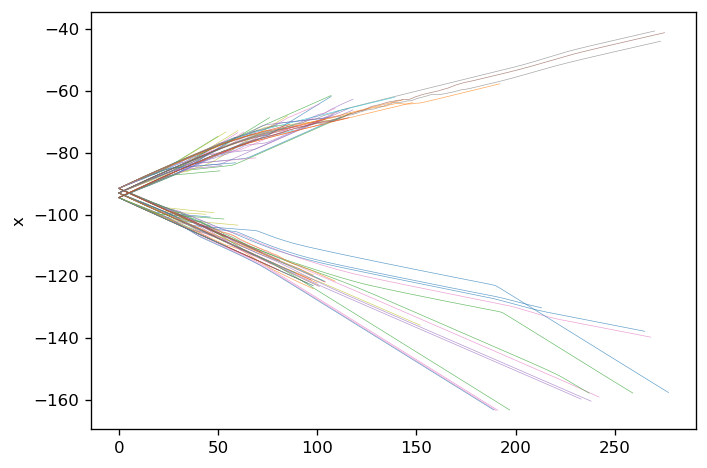

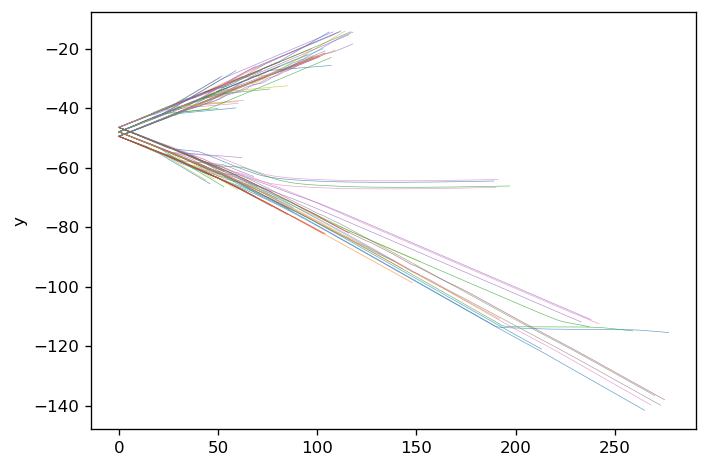

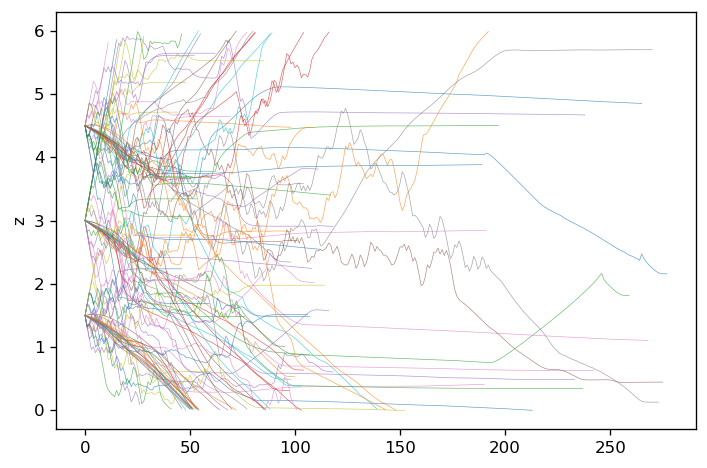

In [63]:
for ax in range(3):
    sts_on_ax = [s[:, ax] for s in tracto.streamlines]
    plt.figure(dpi=120)
    for i, s in enumerate(sts_on_ax):
        plt.plot(s, label=i, lw=0.4, alpha=0.7)
    plt.ylabel(("x", "y", "z")[ax])
    # plt.legend()
    plt.show()

In [ ]:
# plt.plot(streamlines[3, :, 2].cpu().numpy(), label="x")
# plt.plot(streamlines[3, :, 1].cpu().numpy(), label="y")
# plt.plot(streamlines[3, :, 0].cpu().numpy(), label="z")

# plt.legend()

In [ ]:
# im = nib.Nifti1Image(
#     gfa[0].cpu().swapdims(0, 2).numpy(), affine_ras_vox2ras_mm.cpu().numpy(), ref_header
# )

# nib.save(im, str(sample_fod_f.parent / "gfa.nii.gz"))